In [3]:
from pathlib import Path
import requests

DATA_PATH = Path("data")
PATH = DATA_PATH / "mnist"

PATH.mkdir(parents=True, exist_ok=True)

URL = "https://github.com/pytorch/tutorials/raw/main/_static/"
FILENAME = "mnist.pkl.gz"

if not (PATH / FILENAME).exists():
        content = requests.get(URL + FILENAME).content
        (PATH / FILENAME).open("wb").write(content)

In [4]:
import pickle
import gzip

with gzip.open((PATH / FILENAME).as_posix(), "rb") as f:
        ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding="latin-1")

In [15]:

print(y_train[0:50])

[5 0 4 1 9 2 1 3 1 4 3 5 3 6 1 7 2 8 6 9 4 0 9 1 1 2 4 3 2 7 3 8 6 9 0 5 6
 0 7 6 1 8 7 9 3 9 8 5 9 3]


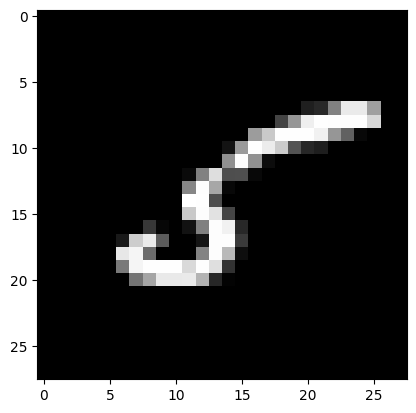

torch.Size([50000, 784])
torch.Size([50000])


In [32]:
from matplotlib import pyplot
import numpy as np

pyplot.imshow(x_train[11].reshape((28, 28)), cmap="gray")
# ``pyplot.show()`` only if not on Colab
try:
    import google.colab
except ImportError:
    pyplot.show()
print(x_train.shape)
print(y_train.shape)


In [19]:
import torch

x_train, y_train, x_valid, y_valid = map(
    torch.tensor, (x_train, y_train, x_valid, y_valid)
)
n, c = x_train.shape
print(x_train, y_train)
print(x_train.shape)
print(y_train.min(), y_train.max())

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]) tensor([5, 0, 4,  ..., 8, 4, 8])
torch.Size([50000, 784])
tensor(0) tensor(9)


In [26]:
import math

weights = torch.randn(784, 10) / math.sqrt(784)
weights.requires_grad_()
bias = torch.zeros(10, requires_grad=True)
print(weights.shape, bias.shape)

torch.Size([784, 10]) torch.Size([10])


In [25]:
def log_softmax(x):
    return x - x.exp().sum(-1).log().unsqueeze(-1)

def model(xb):
    return log_softmax(xb @ weights + bias)

In [35]:
bs = 64  # batch size

xb = x_train[0:bs]  # a mini-batch from x
print(xb.shape)
preds = model(xb)  # predictions
preds[0], preds.shape
print(preds[0], preds.shape)

torch.Size([64, 784])
tensor([-2.4375, -1.8801, -1.9915, -2.3038, -2.4862, -2.1928, -2.5755, -2.3699,
        -2.1981, -3.0317], grad_fn=<SelectBackward0>) torch.Size([64, 10])


In [ ]:
def nll(input, target):
    return -input[range(target.shape[0]), target].mean()

loss_func = nll

In [41]:
yb = y_train[0:bs]
print(loss_func(preds, yb))

tensor(2.3913, grad_fn=<NegBackward0>)


In [42]:
def accuracy(out, yb):
    preds = torch.argmax(out, dim=1)
    return (preds == yb).float().mean()

In [43]:
print(accuracy(preds, yb))


tensor(0.0781)


In [58]:
from IPython.core.debugger import set_trace

lr = 0.5  # learning rate
epochs = 2  # how many epochs to train for

for epoch in range(epochs):
    for i in range((n - 1) // bs + 1):
        #         set_trace()
        start_i = i * bs
        end_i = start_i + bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        with torch.no_grad():
            weights -= weights.grad * lr
            bias -= bias.grad * lr
            weights.grad.zero_()
            bias.grad.zero_()

In [59]:
print(loss_func(model(xb), yb), accuracy(model(xb), yb))

tensor(0.0533, grad_fn=<NllLossBackward0>) tensor(1.)


In [60]:
import torch.nn.functional as F

loss_func = F.cross_entropy

def model(xb):
    return xb @ weights + bias

In [61]:
print(loss_func(model(xb), yb), accuracy(model(xb), yb))

tensor(0.0533, grad_fn=<NllLossBackward0>) tensor(1.)


In [62]:
from torch import nn

class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(784, 10) / math.sqrt(784))
        self.bias = nn.Parameter(torch.zeros(10))

    def forward(self, xb):
        return xb @ self.weights + self.bias